In [26]:
import nilearn
from nilearn import datasets, plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import MultiNiftiLabelsMasker
import os
import requests
import csv
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import scipy
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics.cluster import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
from scipy.sparse.csgraph import minimum_spanning_tree
from collections import deque, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

## **Load data and define functions**

In [ ]:
home_base_dir = '/Users/aj/dmello_lab/fmri_connectivity_trees' # directory where repository lives at home computer
lab_base_dir = '/Users/ajjain/Downloads/Code/fmri_connectivity_trees' # directory where repository lives at lab computer

# set base directory depending on where the code is being run
base_dir = home_base_dir if os.path.exists(home_base_dir) else lab_base_dir

# get msdl and whole brain atlases and coords
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

# get schaefer
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
schaefer_coords = plotting.find_parcellation_cut_coords(labels_img=schaefer.maps)

# concatenate timeseries to get a single timeseries for each subject
def get_timeseries(ids, cort_shape_path, cort_pooled_path):
    timeseries = []
    for id in ids:

        # load the shape and pooled timeseries
        shape = np.loadtxt(f'{cort_shape_path}/{id}.csv', delimiter=',').astype(int)
        pooled = np.loadtxt(f'{cort_pooled_path}/{id}.csv', delimiter=',').reshape(shape)

        # concatenate the timeseries
        timeseries.append(pooled)

    return timeseries

# path for shapes and pooled timeseries
subjects = [
            'MSC01', 
            'MSC03'
            ]
sessions = ['func01', 'func02', 'func03', 'func04', 'func05', 'func06', 'func07', 'func08', 'func09', 'func10']
ids = ['rest']
atlas = 'Schaefer'
atlas_subdir = "schaefer_100"

timeseries = {}
for subject in subjects:
    cort_shape_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/func01/{atlas}/all_tasks/shape/'
    cort_pooled_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/func01/{atlas}/all_tasks/pooled/'
    timeseries[subject] = get_timeseries(ids, cort_shape_path, cort_pooled_path)
    for session in sessions[1:]:
        cort_shape_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/{session}/{atlas}/all_tasks/shape/'
        cort_pooled_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/roi_time_series/{subject}/{session}/{atlas}/all_tasks/pooled/'
        timeseries[subject] = timeseries[subject] + get_timeseries(ids, cort_shape_path, cort_pooled_path)

[get_dataset_dir] Dataset found in /Users/aj/nilearn_data/msdl_atlas

[get_dataset_dir] Dataset found in /Users/aj/nilearn_data/schaefer_2018

In [39]:
def get_concat(timeseries):
    """
    Concatenate the timeseries for each subject.
    """
    concat_timeseries = {}
    for subject, ts in timeseries.items():
        concat_timeseries[subject] = np.concatenate(ts, axis=0).T
    return concat_timeseries


def plot_connectome(cov_matrix, coords, title='connectome', edge_threshold="0%", edge_vmin=0, edge_vmax=1):
    """
    Plot the connectome using the mean correlation matrix and coordinates.
    """
    # Plotting the connectome
    plotting.plot_connectome(
        cov_matrix,
        coords,
        title=title,
        edge_vmin = edge_vmin,
        edge_vmax = edge_vmax,
        edge_cmap='cold_hot',
        edge_threshold=edge_threshold,  # Only plot edges above the 90th percentile
        colorbar=True,
        node_size=10,
    )
    plt.show()


def get_covariance(concat_timeseries, subject='MSC01'):
    """
    Get the covariance matrix of the concatenated timeseries.
    """
    # get the covariance matrix
    cov = np.cov(concat_timeseries[subject])

    for i in range(len(cov)):
        for j in range(len(cov)):
            if i == j:
                cov[i][j] = 0

    return cov


def save_covariance(cov, subject, task="rest", atlas="Schaefer", atlas_subdir="schaefer_100"):
    """
    Save the covariance matrix to a CSV file.
    """
    cov_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/covariance/{subject}/{atlas_subdir}'
    os.makedirs(cov_path, exist_ok=True)
    np.savetxt(f'{cov_path}/{task}.csv', cov, delimiter=',')


def connectivity_measure(concat_timeseries, subject='MSC01', method='correlation'):
    """
    Compute the connectivity measure using the specified method.
    """
    connectivity_measure = ConnectivityMeasure(kind=method)
    cov_matrix = connectivity_measure.fit_transform([concat_timeseries[subject].T])[0]
    
    return cov_matrix

In [103]:
def mutual_information_discrete(x, y, bins=10):
    """
    Estimate mutual information between two continuous variables by discretizing them.

    Parameters:
    x (array-like): First continuous variable.
    y (array-like): Second continuous variable.
    bins (int): Number of bins to use for discretization.

    Returns:
    float: Estimated mutual information.
    """
    # Convert to pandas Series
    x = pd.Series(x)
    y = pd.Series(y)

    # Discretize the continuous values
    x_binned = pd.cut(x, bins=bins, labels=False)
    y_binned = pd.cut(y, bins=bins, labels=False)

    # Compute contingency table
    contingency_table = pd.crosstab(x_binned, y_binned)

    # Compute mutual information
    mi = mutual_info_score(None, None, contingency=contingency_table.values)

    return mi


def get_mutual_info_discrete(concat_timeseries, subject='MSC01', num_bins=10, truncate=True, truncate_timepoint=100):

    if truncate:
        timeseries = concat_timeseries[subject][:, :truncate_timepoint]  # Truncate for debugging
    
    else:
        timeseries = concat_timeseries[subject]
        
    timeseries = timeseries.T  # Transpose to have timepoints as rows and regions as columns
    mutual_info_matrix = np.zeros((timeseries.shape[1], timeseries.shape[1]))

    # get mutual information
    for region in range(timeseries.shape[1]):
        for region2 in range(timeseries.shape[1]):
            if region != region2:
                mutual_info = mutual_information_discrete(timeseries[:, region], timeseries[:, region2], bins=num_bins)
                mutual_info_matrix[region, region2] = mutual_info
    
    return mutual_info_matrix


def mutual_information_continuous(concat_timeseries, subject='MSC01', truncate=True, truncate_timepoint=100):
    
    if truncate:
        timeseries = concat_timeseries[subject][:, :truncate_timepoint]  # Truncate for debugging
    
    else:
        timeseries = concat_timeseries[subject]
    
    regions = timeseries.shape[0]
    # timepoints = timeseries.shape[1]
    
    X = timeseries.T  # Transpose to have timepoints as rows and regions as columns
    mutual_info_matrix = np.zeros((regions, regions))
    
    for i in range(regions):
        mi_vector = mutual_info_regression(X, X[:, i])
        mutual_info_matrix[:, i] = mi_vector
    
    return mutual_info_matrix


def save_mutual_info(mi, subject, task="rest", atlas="Schaefer", atlas_subdir="schaefer_100", discrete=False, num_bins=10):
    """
    Save the covariance matrix to a CSV file.
    """
    mi_path = f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/{subject}/{atlas_subdir}'
    if discrete:
        mi_path = f'{mi_path}/discrete_{num_bins}_bins'
    os.makedirs(mi_path, exist_ok=True)
    np.savetxt(f'{mi_path}/{task}.csv', mi, delimiter=',')
    

In [101]:
# Construct the Chow-Liu tree from continuous data using mutual information.
def get_chow_liu_tree(mi):
    
    # Create a graph
    G = nx.Graph()

    # Add nodes (variables)
    num_variables = mi.shape[0]
    for i in range(num_variables):
        G.add_node(i)

    # Add edges with mutual information as weights
    for i in range(num_variables):
        for j in range(i + 1, num_variables):
            G.add_edge(i, j, weight=mi[i, j])

    # Find the maximum spanning tree
    # The weight parameter specifies the attribute used for edge weights
    chow_liu_tree = nx.maximum_spanning_tree(G, algorithm='kruskal', weight='weight')
    
    return G, chow_liu_tree

## **Calculations**

In [ ]:
# comment out once data is saved

concat_timeseries = get_concat(timeseries)

# calculate and save covariance
# msc01_cov = connectivity_measure(concat_timeseries, subject='MSC01')
# msc03_cov = connectivity_measure(concat_timeseries, subject='MSC03')
# save_covariance(msc01_cov, subject='MSC01', task='rest', atlas=atlas)
# save_covariance(msc03_cov, subject='MSC03', task='rest', atlas=atlas)

In [ ]:
# try mutual info 
# msc01_mutual_info = mutual_information_continuous(concat_timeseries, subject='MSC01', truncate=False)
# save_mutual_info(msc01_mutual_info, subject='MSC01', task='rest', atlas=atlas)
# msc03_mutual_info = mutual_information_continuous(concat_timeseries, subject='MSC03', truncate=False)
# save_mutual_info(msc03_mutual_info, subject='MSC03', task='rest', atlas=atlas)

In [104]:
msc01_mutual_info_disc = get_mutual_info_discrete(concat_timeseries, subject='MSC01', truncate=False, num_bins=10)
save_mutual_info(msc01_mutual_info_disc, subject='MSC01', task='rest', atlas=atlas, discrete=True, num_bins=10)
msc03_mutual_info_disc = get_mutual_info_discrete(concat_timeseries, subject='MSC03', truncate=False, num_bins=10)
save_mutual_info(msc03_mutual_info_disc, subject='MSC03', task='rest', atlas=atlas, discrete=True, num_bins=10)

## **Covariance Connectome plots**

In [20]:
# load covariance matrices

msc01_cov = np.loadtxt(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/covariance/MSC01/schaefer_100/rest.csv', delimiter=',')
msc03_cov = np.loadtxt(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/covariance/MSC03/schaefer_100/rest.csv', delimiter=',')

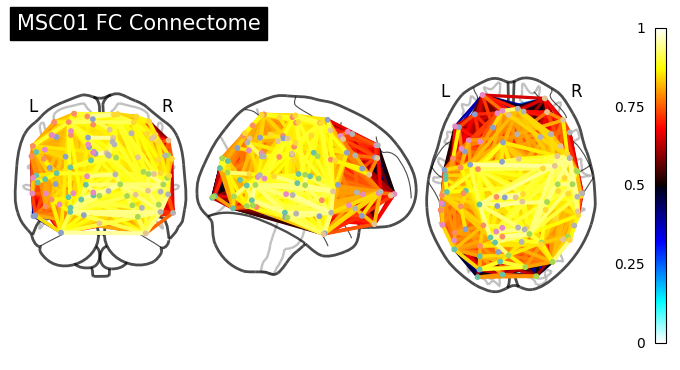

In [ ]:
plot_connectome(msc01_cov, schaefer_coords, title='MSC01 FC Connectome', edge_threshold="0%")

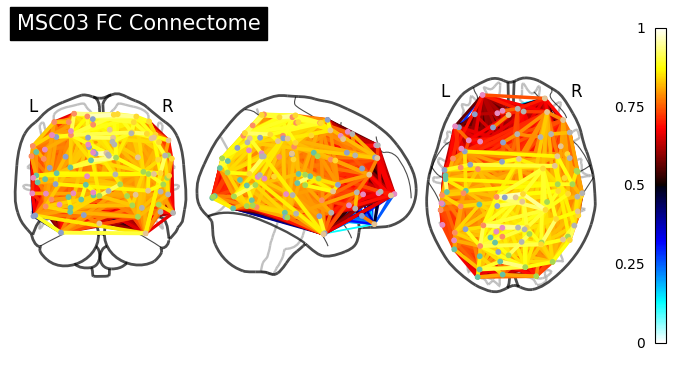

In [25]:
plot_connectome(msc03_cov, schaefer_coords, title='MSC03 FC Connectome', edge_threshold="0%")

## **Mutual info connectome plots**

In [50]:
msc01_mi = np.loadtxt(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/MSC01/schaefer_100/rest.csv', delimiter=',')
msc03_mi = np.loadtxt(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/MSC03/schaefer_100/rest.csv', delimiter=',')

/var/folders/lg/kgxc1tq55372n0km3vwpwdtm0000gn/T/ipykernel_77435/3671990837.py:16: UserWarning: 'adjacency_matrix' is not symmetric.
A directed graph will be plotted.
  plotting.plot_connectome(


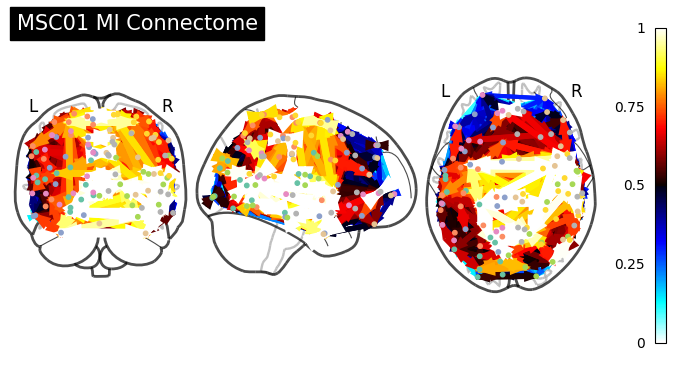

In [52]:
plot_connectome(msc01_mi, schaefer_coords, title='MSC01 MI Connectome', edge_threshold="0%")

/var/folders/lg/kgxc1tq55372n0km3vwpwdtm0000gn/T/ipykernel_77435/3671990837.py:16: UserWarning: 'adjacency_matrix' is not symmetric.
A directed graph will be plotted.
  plotting.plot_connectome(


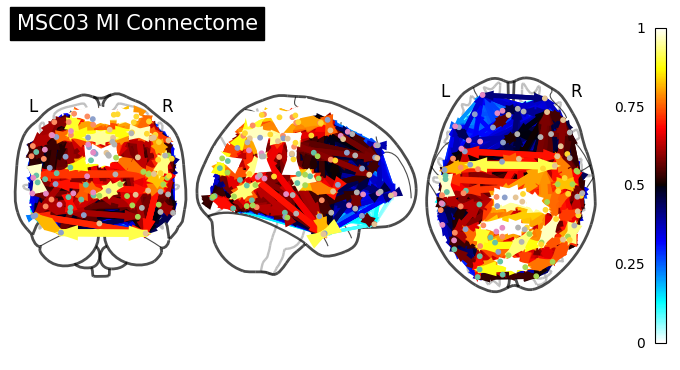

In [53]:
plot_connectome(msc03_mi, schaefer_coords, title='MSC03 MI Connectome', edge_threshold="0%")

In [106]:
msc01_mi_disc10 = np.loadtxt(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/MSC01/schaefer_100/discrete_10_bins/rest.csv', delimiter=',')
msc03_mi_disc10 = np.loadtxt(f'{base_dir}/code/functional_connectivity/midnight_scan_club/output/mutual_information/MSC03/schaefer_100/discrete_10_bins/rest.csv', delimiter=',')

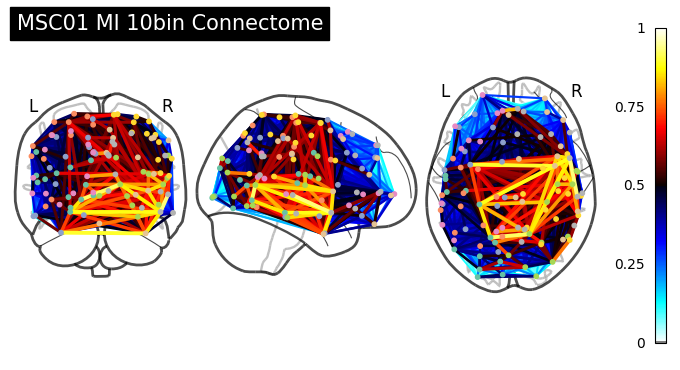

In [107]:
plot_connectome(msc01_mi_disc10, schaefer_coords, title='MSC01 MI 10bin Connectome', edge_threshold="0%")

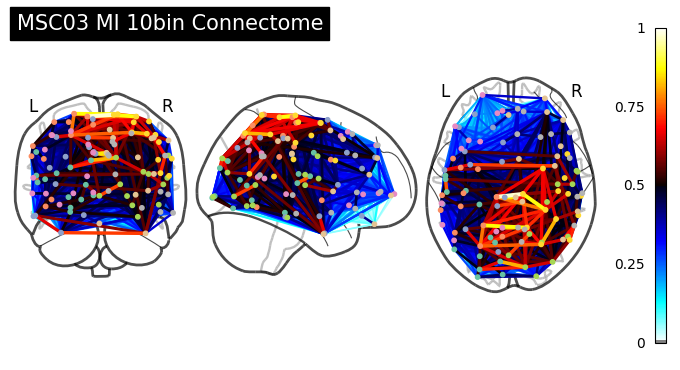

In [108]:
plot_connectome(msc03_mi_disc10, schaefer_coords, title='MSC03 MI 10bin Connectome', edge_threshold="0%")

## **Chow-Liu tree connectome plots**

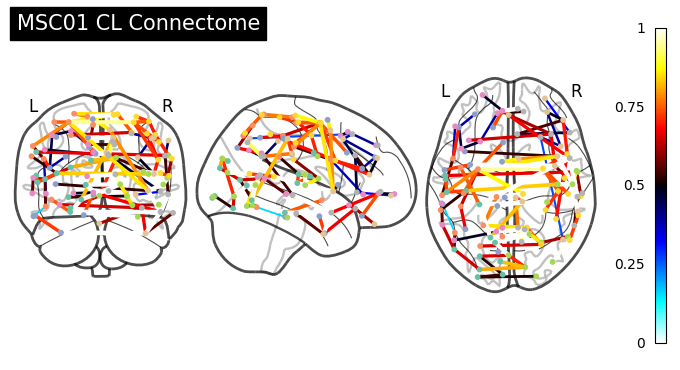

In [69]:
G_msc01, msc01_cl = get_chow_liu_tree(msc01_mi)
msc01_cl_matrix = nx.to_numpy_array(msc01_cl)
plot_connectome(msc01_cl_matrix, schaefer_coords, title='MSC01 CL Connectome', edge_threshold="0%")

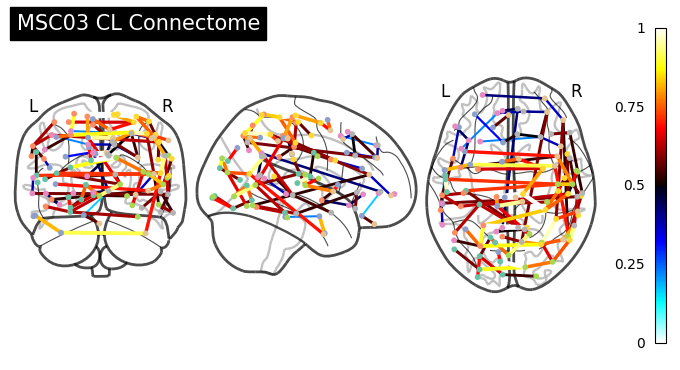

In [70]:
G_msc03, msc03_cl = get_chow_liu_tree(msc03_mi)
msc03_cl_matrix = nx.to_numpy_array(msc03_cl)
plot_connectome(msc03_cl_matrix, schaefer_coords, title='MSC03 CL Connectome', edge_threshold="0%")

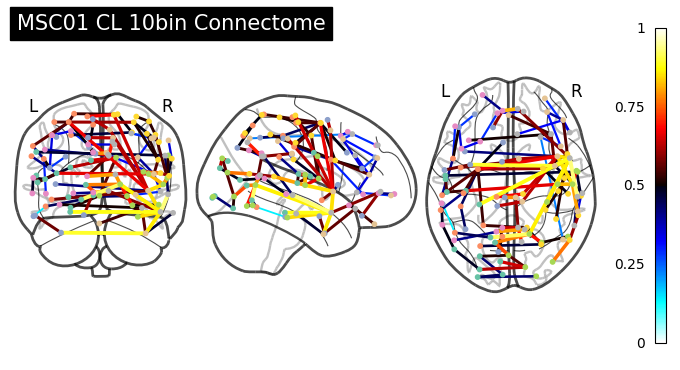

In [109]:
G_msc01_disc10, msc01_cl_disc10 = get_chow_liu_tree(msc01_mi_disc10)
msc01_cl_matrix_disc10 = nx.to_numpy_array(msc01_cl_disc10)
plot_connectome(msc01_cl_matrix_disc10, schaefer_coords, title='MSC01 CL 10bin Connectome', edge_threshold="0%")

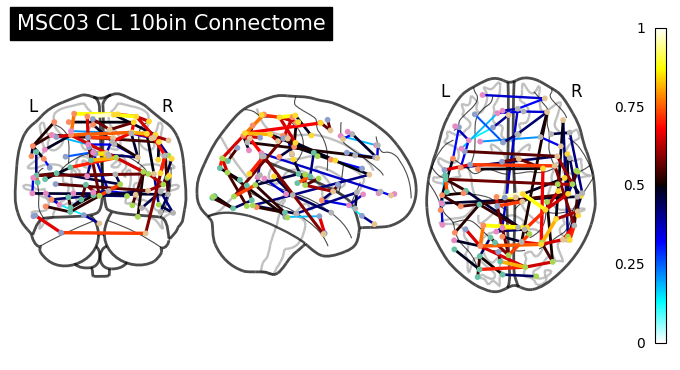

In [110]:
G_msc03_disc10, msc03_cl_disc10 = get_chow_liu_tree(msc03_mi_disc10)
msc03_cl_matrix_disc10 = nx.to_numpy_array(msc03_cl_disc10)
plot_connectome(msc03_cl_matrix_disc10, schaefer_coords, title='MSC03 CL 10bin Connectome', edge_threshold="0%")

## **Chow-Liu tree plots**

In [73]:
def draw_chow_liu_tree(G, root=0):
    """
    Visualize the Chow-Liu tree using a spring layout (no pygraphviz).
    """
    tree = nx.bfs_tree(G, source=root)
    pos = nx.spring_layout(tree, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, arrows=True, node_color="lightblue", 
            edge_color="black", node_size=1500, font_size=12)
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels)

    plt.title("Chow-Liu Tree (Spring Layout)")
    plt.axis("off")
    plt.show()


def hierarchy_pos(G, root=None, width=1., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Hierarchical layout for directed trees. Assigns space to subtrees to avoid squishing.
    """
    def _count_descendants(G, node):
        children = list(G.successors(node))
        if not children:
            return 1
        return sum(_count_descendants(G, child) for child in children)

    def _hierarchy_pos(G, node, left, right, vert_loc, pos):
        center = (left + right) / 2
        pos[node] = (center, vert_loc)
        children = list(G.successors(node))
        if children:
            total = sum(_count_descendants(G, child) for child in children)
            dx = (right - left) / total
            next_left = left
            for child in children:
                size = _count_descendants(G, child)
                next_right = next_left + dx * size
                pos = _hierarchy_pos(G, child, next_left, next_right, vert_loc - vert_gap, pos)
                next_left = next_right
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_loc, {})

def get_node_regions(tree):

    networks = []
    for node in tree.nodes:
        network = str(schaefer.labels[node]).split('_')[2]
        networks.append(network)
    return networks

def draw_hierarchical_tree(G, root=0, title = "Hierarchical Chow-Liu Tree"):
    """
    Draw Chow-Liu tree in a hierarchical top-down format.
    """
    # Ensure it's a directed tree rooted at `root`
    tree = nx.bfs_tree(G, source=root)

    pos = hierarchy_pos(tree, root)

    networks = get_node_regions(tree)

    # Create a color map based on the networks
    color_map = []
    network_names = ['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']

    for node, network in zip(tree.nodes, networks):
        if network in network_names:
            color_map.append(colors[network_names.index(network)])
        else:
            color_map.append(0)
    
    # color_map = np.array(color_map)
    # color_map = color_map / max(color_map)
    
    plt.figure(figsize=(10, 6))
    nx.draw(tree, pos, with_labels=True, node_color=color_map, node_size=140,
            arrows=True, font_size=6, edge_color='gray')


    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    # nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size = 0)

    patches = [mpatches.Patch(color=color, label=network_name) for color, network_name in zip(colors, network_names)]
    plt.legend(handles=patches)

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

    return tree, pos, network_names, colors

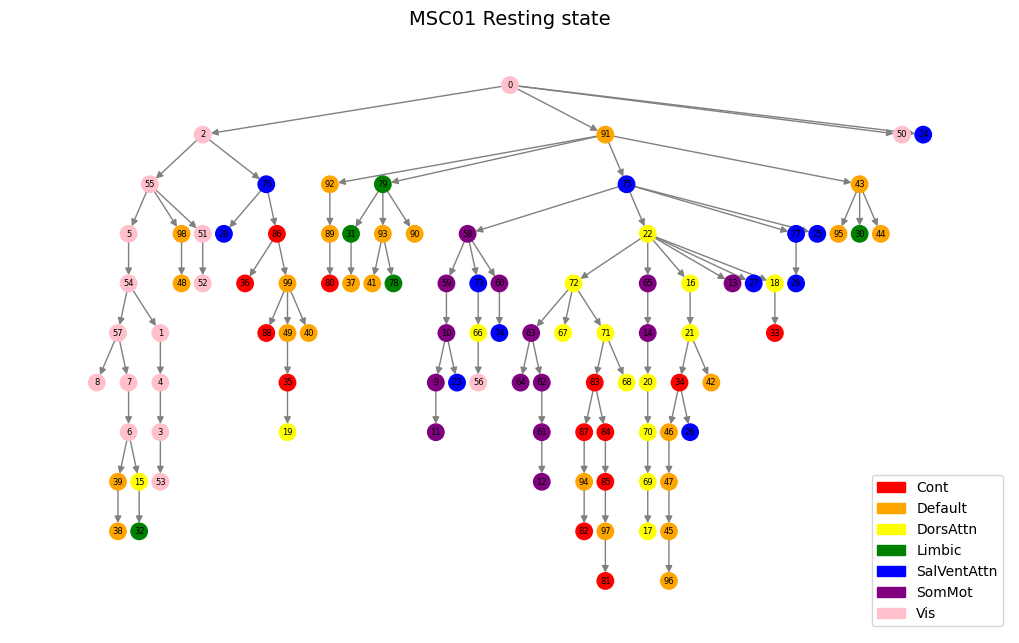

In [76]:
tree, pos, network_names, colors = draw_hierarchical_tree(msc01_cl, root=0, title="MSC01 Resting state")

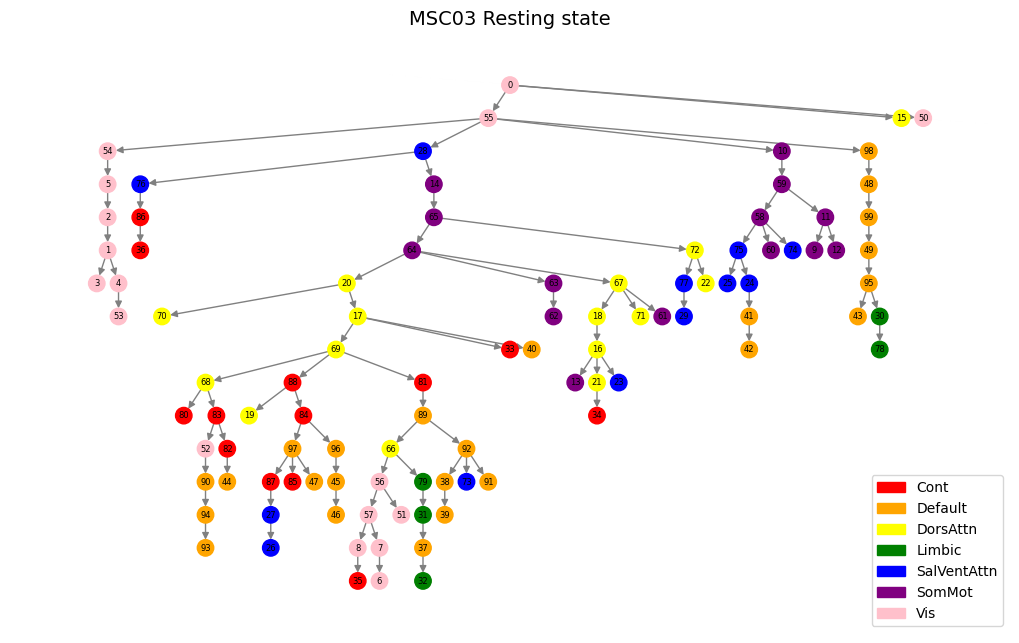

In [81]:
tree, pos, network_names, colors = draw_hierarchical_tree(msc03_cl, root=0, title="MSC03 Resting state")

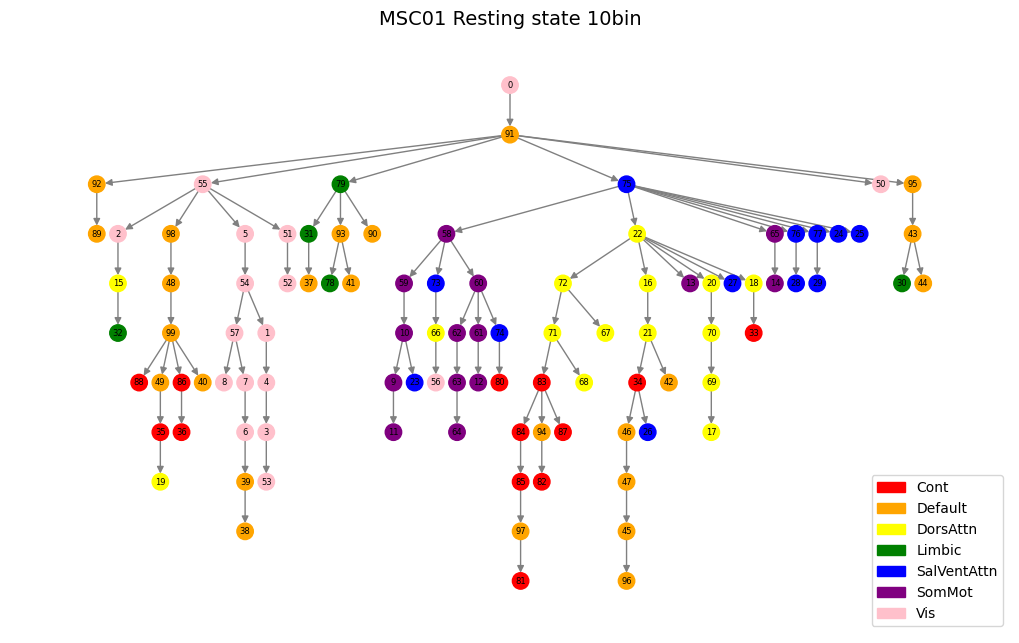

In [112]:
tree, pos, network_names, colors = draw_hierarchical_tree(msc01_cl_disc10, root=0, title="MSC01 Resting state 10bin")

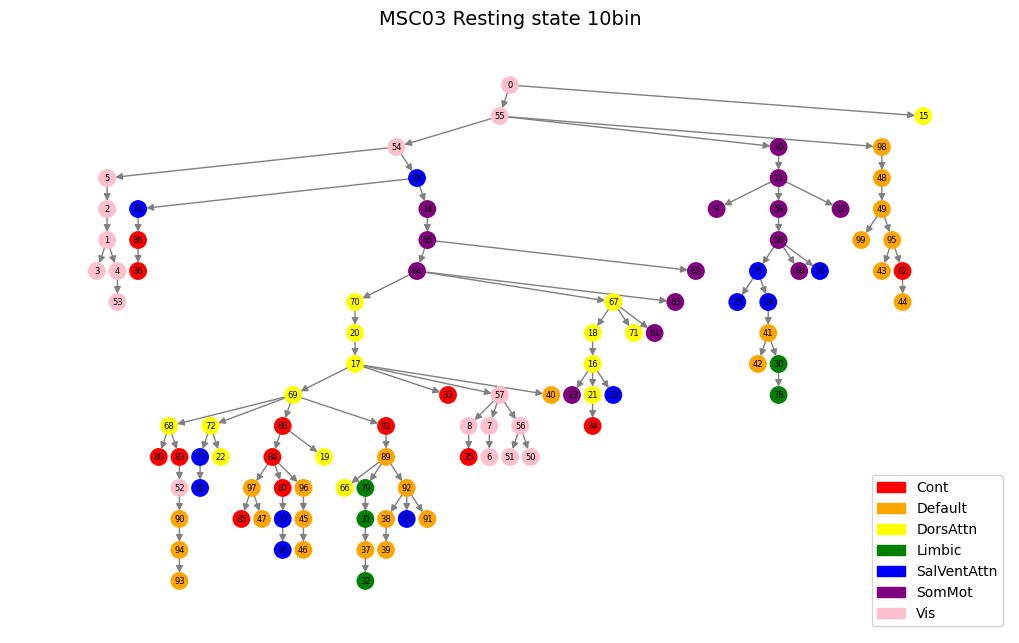

In [113]:
tree, pos, network_names, colors = draw_hierarchical_tree(msc03_cl_disc10, root=0, title="MSC03 Resting state 10bin")

## **How good is Chow-Liu tree at capturing mutual information** ?

In [82]:
print(msc01_mi)

[[7.75291207 0.26928812 1.08494012 ... 0.05689187 0.81972405 0.50938083]
 [0.26928754 7.75266758 0.4324693  ... 0.07799983 0.27923978 0.24323621]
 [1.08492612 0.43246741 7.75275926 ... 0.07191654 0.76122985 0.45872674]
 ...
 [0.05689257 0.07799262 0.07191659 ... 7.75243326 0.09101321 0.14487881]
 [0.81972194 0.27924612 0.76122759 ... 0.09101284 7.75302414 0.62989397]
 [0.50938259 0.24323754 0.45872862 ... 0.14486664 0.6298973  7.75304451]]


In [84]:
print(msc01_cl.edges())

[(0, 2), (0, 91), (0, 50), (0, 24), (1, 54), (1, 4), (2, 55), (2, 76), (3, 4), (3, 53), (5, 54), (5, 55), (6, 7), (6, 39), (6, 15), (7, 57), (8, 57), (9, 11), (9, 10), (10, 59), (10, 23), (12, 61), (13, 22), (14, 65), (14, 20), (15, 32), (16, 22), (16, 21), (17, 69), (18, 33), (18, 22), (19, 35), (20, 70), (21, 34), (21, 42), (22, 72), (22, 65), (22, 75), (22, 27), (25, 75), (26, 34), (28, 76), (29, 77), (30, 43), (31, 79), (31, 37), (34, 46), (35, 49), (36, 86), (38, 39), (40, 99), (41, 93), (43, 95), (43, 91), (43, 44), (45, 96), (45, 47), (46, 47), (48, 98), (49, 99), (51, 55), (51, 52), (54, 57), (55, 98), (56, 66), (58, 75), (58, 59), (58, 73), (58, 60), (60, 74), (61, 62), (62, 63), (63, 72), (63, 64), (66, 73), (67, 72), (68, 71), (69, 70), (71, 72), (71, 83), (75, 91), (75, 77), (76, 86), (78, 93), (79, 91), (79, 93), (79, 90), (80, 89), (81, 97), (82, 94), (83, 87), (83, 84), (84, 85), (85, 97), (86, 99), (87, 94), (88, 99), (89, 92), (91, 92)]


In [91]:
def calculate_fraction_mi_in_cl(mi, cl):
    """
    Calculate the fraction of mutual information that is present in the Chow-Liu tree.
    """
    # remove the diagonal elements from the mutual information matrix
    np.fill_diagonal(mi, 0)
    
    total_mi = np.sum(mi)
    cl_mi = 0
    for edge in cl.edges():
        cl_mi += mi[edge[0], edge[1]]
    
    return cl_mi / total_mi

In [92]:
calculate_fraction_mi_in_cl(msc01_mi, msc01_cl), calculate_fraction_mi_in_cl(msc03_mi, msc03_cl)

(np.float64(0.025936062043428132), np.float64(0.025839493844030326))

In [114]:
calculate_fraction_mi_in_cl(msc01_mi_disc10, msc01_cl_disc10), calculate_fraction_mi_in_cl(msc03_mi_disc10, msc03_cl_disc10)

(np.float64(0.02420807895995722), np.float64(0.02413466890659967))

In [119]:
calculate_fraction_mi_in_cl(msc01_mi, msc01_cl_disc10), calculate_fraction_mi_in_cl(msc03_mi, msc03_cl_disc10)

(np.float64(0.025770081820125045), np.float64(0.025768221740594108))

In [117]:
def threshold_covariance_matrix(cov_matrix, threshold=0.9):
    """
    Threshold the covariance matrix to create a binary adjacency matrix.
    """
    adj_matrix = np.where(cov_matrix > threshold, 1, 0)
    np.fill_diagonal(adj_matrix, 0)  # Remove self-loops
    return adj_matrix

def calculate_fraction_mi_in_adj(mi, adj):
    
    total_mi = np.sum(mi)
    adj_mi = 0
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i, j] == 1:
                adj_mi += mi[i, j]
    return adj_mi / total_mi

In [118]:
calculate_fraction_mi_in_adj(msc01_mi, threshold_covariance_matrix(msc01_cov, threshold=0.9)), calculate_fraction_mi_in_adj(msc03_mi, threshold_covariance_matrix(msc03_cov, threshold=0.9))

(np.float64(0.030758094936430395), np.float64(0.013646602490585089))